Number of principal components to contain 95.0% of variance: 12


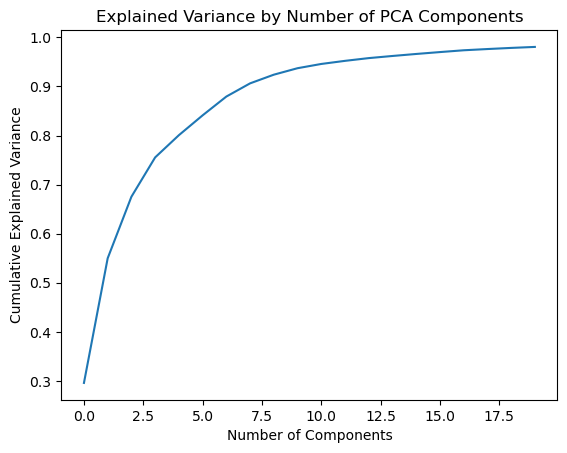

/home/harry/miniconda3/envs/biogas/lib/python3.11/site-packages/pymatgen/io/cif.py:1120: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Predicting  1  properties!!
Epoch: [0][0/917]	Loss 216.4147 (216.4147)	MAE 9.966 (9.966)
Epoch: [0][10/917]	Loss 42.5864 (152.3770)	MAE 4.512 (7.769)
Epoch: [0][20/917]	Loss 1.7901 (99.9565)	MAE 0.856 (5.955)
Epoch: [0][30/917]	Loss 2.1222 (73.1878)	MAE 0.804 (4.877)
Epoch: [0][40/917]	Loss 3.0994 (56.7809)	MAE 1.184 (4.064)
Epoch: [0][50/917]	Loss 1.8533 (46.1437)	MAE 0.866 (3.462)
Epoch: [0][60/917]	Loss 0.9445 (38.7303)	MAE 0.549 (2.990)


In [3]:
from mof import MOF_CGCNN
import csv
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def create_single_label_df(molecule, target_pressure):
    data_all_labels = pd.read_csv(f'{molecule}_data_all_labels.csv')
    data_all_labels.drop('surface_area_m2g', axis=1, inplace=True)

    target_pressure = f'{target_pressure}'
    columns_to_keep = ['id', 'surface_area_m2cm3', 'void_fraction', 'lcd', 'pld', target_pressure]
    data_single_label = data_all_labels.copy()
    data_single_label = data_single_label[columns_to_keep]
    data_single_label.rename(columns={target_pressure: 'target'}, inplace=True)

    # Reorder the columns as 'id', 'surface_area_m2_cm3', 'void_fraction', 'lcd', 'pld', 'target'
    column_order = ['id', 'surface_area_m2cm3', 'void_fraction', 'lcd', 'pld', 'target']
    data_single_label = data_single_label.reindex(columns=column_order)
    data_single_label = data_single_label.set_index('id')
    return data_single_label

def find_directory():
    """Finds the directory of the python script or Jupyter notebook.

    Returns:
        directory (str): directory of script.
    """
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':  # If running in a Jupter notebook
            directory = os.getcwd()
        else:
            directory = Path(__file__).parent
    except NameError:
        directory = Path(__file__).parent
    return directory

def get_cif_IDs():
    directory = find_directory()
    cif_directory = f'{directory}/cif'
    filenames = os.listdir(cif_directory)

    # Remove file extensions and return list
    cif_ids = [Path(file).stem for file in filenames if os.path.isfile(os.path.join(cif_directory, file))]
    return cif_ids

def build_dataset(molecule, target_pressure, include_RDFs):
    # Make dataframe with single label at a given pressure
    data_single_label = create_single_label_df(molecule, target_pressure)

    # Filter dataframe so that it only contains MOFs that have corresponding cif files
    cif_ids = get_cif_IDs()
    data_single_label = data_single_label[data_single_label.index.isin(cif_ids)]
    
    # Optionally add RDF descriptors
    if include_RDFs:
        data_single_label = add_RDFs(data_single_label)

    # Save csv as training+validation set
    data_single_label.to_csv('data.csv', header=False)
    return data_single_label

def apply_PCA_to_RDFs(contained_variance=0.95):
    RDFs = pd.read_csv('RDFs.csv')
    structure_names = RDFs['Structure_Name']
    #Data pre-processing and analysis

    #Feature normalisation.
    RDFs = RDFs.drop('Structure_Name', axis=1)

    # Normalise the features to use zero mean normalisation
    scaler = StandardScaler()
    scaled_RDFs = scaler.fit_transform(RDFs)
    
    #Apply PCA for dimensionality reduction
    pca = PCA(n_components=20)
    PCs_of_RDFs = pca.fit_transform(scaled_RDFs)

    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    n_over_threshold = len(explained_variance[explained_variance < contained_variance])
    print(f"Number of principal components to contain {contained_variance*100}% of variance:", n_over_threshold + 1)
    plt.plot(explained_variance)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Number of PCA Components')
    plt.show()
    
    PCs_of_RDFs = pd.DataFrame(PCs_of_RDFs[:,0:(n_over_threshold + 1)])
    PCs_of_RDFs.set_index(structure_names, inplace=True)
    PCs_of_RDFs.rename_axis('id', inplace=True)

    # Generate a list of new column names
    new_columns = ['PC' + str(i+1) for i in range(PCs_of_RDFs.shape[1])]
    # Rename the columns
    PCs_of_RDFs.columns = new_columns
    return PCs_of_RDFs

def add_RDFs(data_single_label):
    PCs_of_RDFs = apply_PCA_to_RDFs(contained_variance=0.95)
    data_single_label = data_single_label.join(PCs_of_RDFs)
    return data_single_label

def split_dataset(molecule, target_pressure, train_val_test_split, include_RDFs):
    data_single_label = build_dataset(molecule, target_pressure, include_RDFs)

    # Split away the test set
    training_val_set, test_set = train_test_split(data_single_label, test_size=train_val_test_split[2], random_state=42)

    # Save these dataframes as .csv files
    training_val_set.to_csv('training_val.csv', header=False)
    test_set.to_csv('test.csv', header=False)

# --- Hyperparameters ---
molecule = 'co2'
target_pressure = 0.1
train_val_test_split = [0.7, 0.2, 0.1]
epochs = 200
initial_lr = 0.001
lr_decay_rate = 0.9
include_RDFs = True
# -----------------------
    
split_dataset(molecule, target_pressure, train_val_test_split, include_RDFs)

##read data
with open('./training_val.csv') as f:
    readerv = csv.reader(f)
    trainandval = [row for row in readerv]
with open('./test.csv') as f:
    readerv = csv.reader(f)
    test = [row for row in readerv]

test_size = train_val_test_split[1] / (1 - train_val_test_split[2])
train, val = train_test_split(trainandval, test_size=test_size, random_state=24)
#file path
root = './cif'
#create a class
mof = MOF_CGCNN(cuda=True,
                root_file=root,
                trainset = train,
                valset=val,
                testset=test,
                epoch = epochs,
                lr=initial_lr,
                optim='Adam',
                batch_size=24,
                h_fea_len=480,
                n_conv=5,
                lr_milestones=[200],
                lr_decay_rate=lr_decay_rate,
                weight_decay=1e-7,
                dropout=0.2)
# train the model
mof.train_MOF()